In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import metrics as mt
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import distance_metrics

from scipy.spatial.distance import cdist, pdist, squareform

In [50]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-1.train"
TS_PATH = "./monks/datasets/monks-1.test"

In [51]:
from collections import Counter

class KNN(BaseEstimator):
    def __init__(self, k=3, metric="euclidean"):
        self.k = k
        self.metric_evaluator = mt.get_metric_evaluator(metric)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for row in X:
            label = self.closest(row)
            predictions.append(label)
        return predictions
    
    def closest(self, row):        
        distances = []

        for x_train in self.X_train:
            distances.append(self.metric_evaluator(row, x_train))

        k_indices = np.argsort(distances)[:self.k]
        k_nns_labels = []
        for i in k_indices:
            k_nns_labels.append(self.y_train[i])


        results = Counter(k_nns_labels).most_common()
        return results[0][0]
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.sum(predictions == y) / len(y)
    



In [52]:
distance_metrics()["euclidean"]([[1,5,3]], [[1,2,3]])

array([[3.]])

In [53]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  df = pd.read_csv(path, sep=" ", names=['NaN','y','x1','x2','x3','x4','x5','x6','garbage'])
  y, df = df['y'], df.drop(columns=['NaN','garbage','y'])
  
  # One-hot encoding categorical variables
  df = pd.get_dummies(df, columns=['x1','x2','x3','x4','x5','x6']).astype('int')

  return (df, y)

In [54]:
# read training and test set
X_train, y_train = read_ds(TR_PATH)
X_test,  y_test  = read_ds(TS_PATH)

In [55]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x1_1    124 non-null    int64
 1   x1_2    124 non-null    int64
 2   x1_3    124 non-null    int64
 3   x2_1    124 non-null    int64
 4   x2_2    124 non-null    int64
 5   x2_3    124 non-null    int64
 6   x3_1    124 non-null    int64
 7   x3_2    124 non-null    int64
 8   x4_1    124 non-null    int64
 9   x4_2    124 non-null    int64
 10  x4_3    124 non-null    int64
 11  x5_1    124 non-null    int64
 12  x5_2    124 non-null    int64
 13  x5_3    124 non-null    int64
 14  x5_4    124 non-null    int64
 15  x6_1    124 non-null    int64
 16  x6_2    124 non-null    int64
dtypes: int64(17)
memory usage: 16.6 KB


In [56]:
# KNN
clf = KNN(k=5)
clf.fit(X_train.values, y_train.values)
  
predictions = clf.predict(X_test.values)


acc = np.sum(predictions == y_test) / len(y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.8055555555555556


In [57]:
def grid_search(metrics, n_neighbors, X_train, y_train, X_test, y_test):
  best_score = 0
  best_k = 0
  best_model = None
  best_metric = None

  for k in n_neighbors:
    for metric in metrics:
      model = KNN(k)
      model.fit(X_train.values, y_train.values)
      predictions = model.predict(X_test.values)
      score = np.sum(predictions == y_test) / len(y_test)

      if score > best_score:
        best_score = score
        best_k = k
        best_model = model
        best_metric = metric
        
  return best_model, best_k, best_score, best_metric

In [58]:
from sklearn.model_selection import GridSearchCV, KFold


cv = KFold(n_splits=5, shuffle=True, random_state=7)
param_grid = {
    "k": [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 50],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}
grid = GridSearchCV(KNN(), param_grid, cv=cv, n_jobs=-1)


In [60]:
#grid_result = grid_search(metrics=['euclidean', 'euclidean','manhattan','chebyshev','minkowski'], n_neighbors=range(1,25), X_train=X_train, y_train=y_train,X_test=X_test, y_test=y_test)

grid_result = grid.fit(X_train.values, y_train.values)

#print("Best k: " + str(grid_result[1]) + " best metric:" + grid_result[3] + " score: " + str(grid_result[2]))

knn = grid_result.best_estimator_

AttributeError: 'KNN' object has no attribute 'metric'

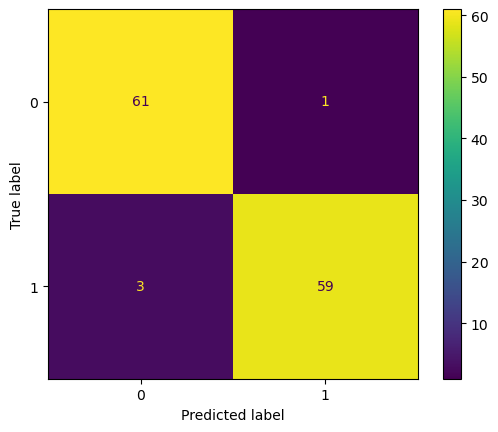

In [76]:
# Tr Confusion Matrix
predictions = knn.predict(X_train.values)
cm = confusion_matrix(y_train.values, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

KNN Assessment: 0.8101851851851852


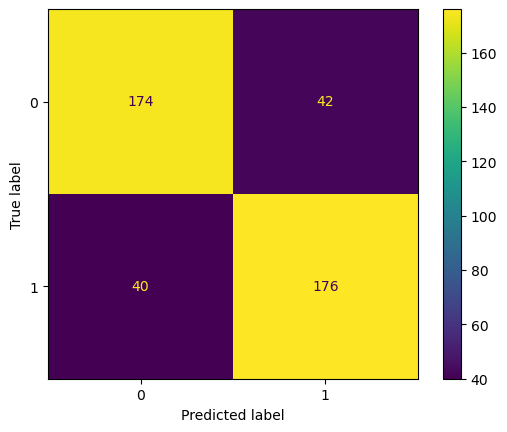

In [77]:
# Test
print("KNN Assessment: " + str(knn.score(X_test.values, y_test.values)))

# Ts Confusion Matrix
predictions = knn.predict(X_test.values)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()